In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import random
import timeit
from scipy.spatial import distance as dst
import itertools
import pickle
import scipy.stats as stats

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
import seaborn as sns
#sns.set_theme(style="whitegrid")
#from scipy.stats.stats import spearmanr
#from scipy.stats.stats import pearsonr
from scipy.stats import skew   
import networkx as nx
name_list = ['human_neuron','rat_neuron',
            'monkey_neuron','zebrafish_neuron',
    'vascular_2','vascular_3','vascular_1','mitochondrial','root_1','root_2','anthill','fruit_fly_2','fruit_fly_3','fruit_fly_4','fruit_fly_1']
color_dict = {'root_1':'green','root_2':'olive','mitochondrial':'y','vascular_1':'red','vascular_2':'crimson','vascular_3':'salmon',
              'fruit_fly_2':'purple','fruit_fly_3':'pink','tree':'brown','rat_neuron':'magenta','human_neuron':'indigo',
              'anthill':'silver','fruit_fly_1':'deeppink','fruit_fly_4':'plum','zebrafish_neuron':'blue','monkey_neuron':'teal'}

category_color_dict = {'root_1':'green','root_2':'green','mitochondrial':'blue','vascular_1':'b','vascular_2':'blue','vascular_3':'blue',
              'fruit_fly_2':'red','fruit_fly_3':'red','tree':'green','rat_neuron':'green','human_neuron':'green',
              'anthill':'green','fruit_fly_1':'red','fruit_fly_4':'red','zebrafish_neuron':'green','monkey_neuron':'green'}
name_change_dict = {'mitochondrial':'mitochon','human_neuron':'h_neuron','monkey_neuron':'m_neuron','rat_neuron':'r_neuron','zebrafish_neuron':'z_neuron'}
ordered_name_list =['root_1','root_2','human_neuron','zebrafish_neuron','monkey_neuron',
                'rat_neuron','anthill','vascular_1','vascular_2','vascular_3',
                'mitochondrial','fruit_fly_1','fruit_fly_2','fruit_fly_3','fruit_fly_4']
t_std = {}
t_1_distribution_dict = {}

def compute_iqr(x):
    q75, q25 = np.percentile(x, [75 ,25])
    iqr = q75 - q25
    return iqr


def segment_data_zero(dataframe):
    """
    Segment the dataframe into top 50% and bottom 50% based on a specific column.
    
    :param dataframe: The DataFrame to segment.
    :return: Two DataFrames representing the top 50% and bottom 50% segments.
    """
    median_value = dataframe['Link_confinement'].median()
    top_half = dataframe[dataframe['Link_confinement'] >= 0.00001]
    bottom_half = dataframe[dataframe['Link_confinement'] < 0.00001]
    return top_half, bottom_half

In [3]:
path_source_1 = '2. directed_metagraph_weights/'
path_source_2 = '../2. basic_measures/0. link_properties/'
path_source_3 = '../3. abstract_network_results/1. network_measures_results/'
name_df = {}
corr_intersections_l_volume_dict = {'name':[],'spearman_correlation':[],'p_value':[]}
corr_intersections_l_cs_dict = {'name':[],'spearman_correlation':[],'p_value':[]}
corr_l_cs_volume_dict =  {'name':[],'spearman_correlation':[],'p_value':[]}
corr_l_cs_length_dict ={'name':[],'spearman_correlation':[],'p_value':[]}
corr_l_segments_cs_dict = {'name':[],'spearman_correlation':[],'p_value':[]}
corr_l_segments_volume_dict = {'name':[],'spearman_correlation':[],'p_value':[]}
corr_dict = {}
pval_dict = {}
link_name_dictionary = {}
corr_method = 'kendall'
top_dfs_dict = {}
bottom_dfs_dict = {}
name_link_confinement_dict = {}
for name in name_list:
    #print(name)
    infile = open(path_source_1 +  name + "_weighted_results.pickle",'rb')
    intersection_metagraph = pickle.load(infile)
    metagraph_out_degree_weight_sum = intersection_metagraph['metagraph_out_degree_weight_sum']
    metagraph_in_degree_weight_sum = intersection_metagraph['metagraph_in_degree_weight_sum']
    connectome_out_degree_weight_sum = intersection_metagraph['connectome_out_degree_weight_sum']
    connectome_in_degree_weight_sum = intersection_metagraph['connectome_in_degree_weight_sum']
    infile_2 = open(path_source_2 +  name + "_basic_results.pkl",'rb')
    basic_results = pickle.load(infile_2)
    
    
    meta_connectome_deg_diff = {}
    for path_id in connectome_out_degree_weight_sum.keys():
        meta_connectome_deg_diff[path_id] = metagraph_out_degree_weight_sum[path_id] -  connectome_out_degree_weight_sum[path_id] + metagraph_in_degree_weight_sum[path_id] -  connectome_in_degree_weight_sum[path_id]
    name_link_confinement_dict[name] =  meta_connectome_deg_diff.values()
    infile  = open(path_source_3 + name + "_network_measures_dict.pkl",'rb')
    network_results = pickle.load(infile)
    
    
    path_id_list = set(list(connectome_out_degree_weight_sum.keys()) + list(connectome_in_degree_weight_sum.keys()))
    link_dictionary = {'Path_id':[],'Complementary_straightness':[],'Link_volume':[], 'Link_confinement':[],'Link_degree' :[],'Link_betw':[],'Link_path_length':[],'Link_segments':[]}
    for path_id in path_id_list:
        link_dictionary['Path_id'].append(path_id)
        link_dictionary['Complementary_straightness'].append(basic_results['c_straightness'][path_id])
        link_dictionary['Link_path_length'].append(basic_results['link_path_length'][path_id])
        link_dictionary['Link_volume'].append(basic_results['link_volume_normed'][path_id])
        link_dictionary['Link_confinement'].append( meta_connectome_deg_diff[path_id])
        link_dictionary['Link_degree'].append(network_results['link_degree_dict'][path_id])
        link_dictionary['Link_betw'].append(network_results['betw_dict'][path_id])
        link_dictionary['Link_segments'].append(basic_results['link_segments'][path_id])
    link_name_dictionary[name] = link_dictionary
    link_df= pd.DataFrame(link_dictionary)
    sorted_link_df = link_df.sort_values(by='Link_confinement', ascending=False)

    # Segment the data
    top_dfs_dict[name], bottom_dfs_dict[name] =  segment_data_zero(sorted_link_df)

    link_corr = link_df.corr().copy()
    mean_meta_connectome_diff = np.mean(list(meta_connectome_deg_diff.values()))
    if name in name_change_dict.keys():
        name = name_change_dict[name]
    network_dictionary = {'Name':[name],
                         'corr_intersections_l_volume' :[link_corr['Link_confinement']['Link_volume']],
                         'corr_intersections_c_straightness' :[link_corr['Link_confinement']['Complementary_straightness']]}
    name_df[name] = pd.DataFrame( network_dictionary).round(2)
    rho =link_df.corr(method=corr_method)
    pval = link_df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
    
    corr_dict[name] = rho
    pval_dict[name] = pval
        
    #Intersections and link volume
    corr_intersections_l_volume_dict['name'].append(name)
    corr_intersections_l_volume_dict['spearman_correlation'].append(rho['Link_confinement']['Link_volume'])
    corr_intersections_l_volume_dict['p_value'].append(np.round(pval['Link_confinement']['Link_volume'],5))

    #Intersections and link volume
    corr_intersections_l_cs_dict['name'].append(name)
    corr_intersections_l_cs_dict['spearman_correlation'].append(rho['Link_confinement']['Complementary_straightness'])
    corr_intersections_l_cs_dict['p_value'].append(np.round(pval['Link_confinement']['Complementary_straightness'],5))
    
    #Compl straightness and link volume
    
    corr_l_cs_volume_dict['name'].append(name)
    corr_l_cs_volume_dict['spearman_correlation'].append(rho['Link_volume']['Complementary_straightness'])
    corr_l_cs_volume_dict['p_value'].append(np.round(pval['Link_volume']['Complementary_straightness'],5))
    
    #Compl straightness and link path length
    corr_l_cs_length_dict['name'].append(name)
    corr_l_cs_length_dict['spearman_correlation'].append(rho['Link_path_length']['Complementary_straightness'])
    corr_l_cs_length_dict['p_value'].append(np.round(pval['Link_path_length']['Complementary_straightness'],5))
    
     #Compl straightness and segments per link
    corr_l_segments_cs_dict ['name'].append(name)
    corr_l_segments_cs_dict ['spearman_correlation'].append(rho['Link_segments']['Complementary_straightness'])
    corr_l_segments_cs_dict ['p_value'].append(np.round(pval['Link_segments']['Complementary_straightness'],5))    
        
        
    #Link volume and segments per link
    
    corr_l_segments_volume_dict ['name'].append(name)
    corr_l_segments_volume_dict ['spearman_correlation'].append(rho['Link_segments']['Link_volume'])
    corr_l_segments_volume_dict ['p_value'].append(np.round(pval['Link_segments']['Link_volume'],5))    

path_save = '3. link_df_properties/'
for name in name_list:
    #print(name)
    pd.DataFrame(link_name_dictionary[name]).to_csv(path_save + name + '_link_properties.csv')        

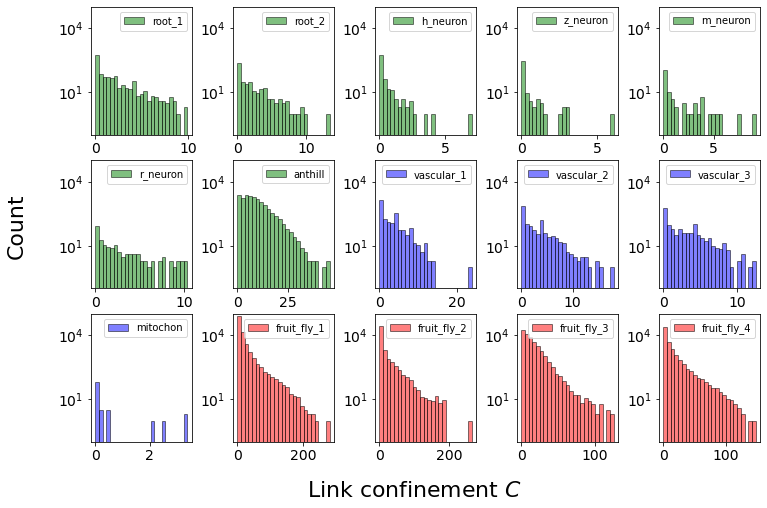

In [4]:
# All values have + 0.09999 added to av# Assuming necessary variables (name_list, name_change_dict, category_color_dict, name_link_confinement_dict) are defined
fig, axs = plt.subplots(3, 5, figsize=(12, 8),gridspec_kw={'hspace': 0.2, 'wspace': 0.4})
#fig.suptitle('Local density distribution')
#['vascular_1','tree','mouse_brain','mitochondrial','anthill','root_1','root_2','fruit_fly_2','fruit_fly_3','human_brain']

ij_name_dict = {'root_1':(0,0),'root_2':(0,1),'anthill':(1,1),'zebrafish_neuron':(0,3) ,'monkey_neuron':(0,4)
                ,'rat_neuron':(1,0), 'human_neuron':(0,2),'vascular_1':(1,2),'vascular_2':(1,3),'vascular_3':(1,4)
                ,'mitochondrial':(2,0),'fruit_fly_1':(2,1),'fruit_fly_2':(2,2),'fruit_fly_3':(2,3),'fruit_fly_4':(2,4)}
#sensitivity = 0.099999
# Corrected variable name spelling
sensitivity = 0 

for name in name_list:
    if name in name_change_dict.keys():
        label_name = name_change_dict[name]
    else:
        label_name = name
    
    # Preparing data
    name_link_confinement_list = [x + sensitivity for x in name_link_confinement_dict[name]]
    
    # Getting subplot indices
    i, j = ij_name_dict[name]
    
    # Plotting histogram
    axs[i][j].hist(name_link_confinement_list, color=category_color_dict[name], label=label_name,bins=25, alpha=0.5, edgecolor='black')
    
    # Setting scale, limits, ticks, and labels
    axs[i][j].set_yscale('log')
    axs[i][j].set_ylim(0.1001, 100000)
   # axs[i][j].set_xlim(0, 200)
    axs[i][j].set_yticks([10,10000]) 
    #axs[i][j].set_xticklabels(['$0$', '$10^{2}$']) 
    #
    # Setting individual x and y labels
    #axs[i][j].set_xlabel('Link confinement $C$')
    #axs[i][j].set_ylabel('Count')
    
    axs[i][j].legend()
    
#for ax in axs.flat:
#     ax.label_outer()

fig.text(0.5, 0.04, 'Link confinement $C$', ha='center', va='center',fontsize=22)
fig.text(0.04, 0.5, 'Count', ha='center', va='center', rotation='vertical',fontsize=22)
plt.savefig('link_confinement_distribution.pdf', format='pdf',dpi=1200)  

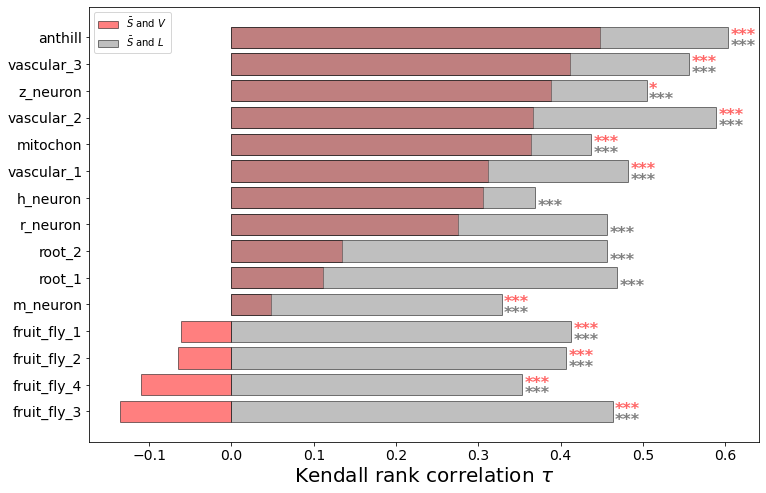

In [5]:
df_volume_cs = pd.DataFrame(corr_l_cs_volume_dict)
df_volume_cs = df_volume_cs.sort_values(by=['spearman_correlation'])

df_length_cs  = pd.DataFrame(corr_l_cs_length_dict )
df_length_cs = df_length_cs.reindex(index=df_volume_cs.index)
plt.figure(figsize=(12,8))
ax_1 = plt.barh(df_volume_cs['name'],df_volume_cs['spearman_correlation'],alpha=0.5,edgecolor='black',orientation='horizontal',color='red',label=r'$\bar{S}$'+ ' and $V$')
ax_2 = plt.barh(df_length_cs['name'],df_length_cs['spearman_correlation'],alpha=0.5,edgecolor='black',orientation='horizontal',color='gray',label=r'$\bar{S}$'+ ' and $L$')
plt.xlabel('Kendall rank correlation ' + r'$\tau$')
#plt.yticks(rotation = 45);
plt.legend(loc='upper left')

for index,i in enumerate(ax_2.patches):
    p_value =  df_length_cs['p_value'].iloc[index]
    p_string = ''
    if p_value < 0.01:
        p_string = '***'
    elif p_value <0.05:
        p_string = '**'
    elif p_value <0.1:
        p_string = '*'
    plt.text(i.get_width()+0.003, i.get_y()- 0.1,
             p_string,
             fontsize=16, fontweight='bold',
             color='grey')
    
for index,i in enumerate(ax_2.patches):
    p_value =  df_volume_cs['p_value'].iloc[index]
    p_string = ''
    if p_value < 0.01:
        p_string = '***'
    elif p_value <0.05:
        p_string = '**'
    elif p_value <0.1:
        p_string = '*'
    plt.text(i.get_width()+0.003, i.get_y()+0.3,
            p_string,
             fontsize=16, fontweight='bold',
             color='red',alpha = 0.6)
plt.savefig('cs_corr.pdf', format='pdf',dpi=1200)

In [6]:
corr_tree = {}
pvalue_tree = {}
corr_lattice = {}
pvalue_lattice = {}
corr_linked_trees = {}
pvalue_linked_trees = {}
for name in name_list[:]:
    if name in name_change_dict:
        name = name_change_dict[name]
    if ('vascular' in name) or ('mito' in name):
        corr_lattice[name] = corr_dict[name]
        pvalue_lattice[name] =  pval_dict[name] 
    elif ('fruit_fly' in name):
        corr_linked_trees[name] = corr_dict[name]
        pvalue_linked_trees[name] =  pval_dict[name] 
    else:
        corr_tree[name] = corr_dict[name]
        pvalue_tree[name] = pval_dict[name]

In [7]:
corrleation_profile_lattice = {}
correlation_p_values_lattice = {}
for network in corr_lattice.keys():
    corrleation_profile_lattice[network] = {}
    correlation_p_values_lattice[network] = {}
    for measure in corr_lattice[network ]['Link_confinement'].index:
        if measure != 'Path_id' and measure != 'Link_confinement' and measure != 'Link_segments' and measure!='Link_path_length' :
            correlation_p_values_lattice[network][measure] = pvalue_lattice[network]['Link_confinement'][measure]
            p = correlation_p_values_lattice[network][measure] 
            corrleation_profile_lattice[network][measure] = corr_lattice[network]['Link_confinement'][measure]

In [8]:
def calculate_correlation_profiles(corr_dict, pval_dict):
    correlation_profile = {}
    correlation_p_values = {}
    for network in corr_dict.keys():
        correlation_profile[network] = {}
        correlation_p_values[network] = {}
        for measure in corr_dict[network]['Link_confinement'].index:
            if measure not in ['Path_id', 'Link_confinement', 'Link_segments', 'Link_path_length']:
                correlation_p_values[network][measure] = pval_dict[network]['Link_confinement'][measure]
                correlation_profile[network][measure] = corr_dict[network]['Link_confinement'][measure]
    return correlation_profile, correlation_p_values

# Calculating for all categories
corr_profile_tree, pvalue_profile_tree = calculate_correlation_profiles(corr_tree, pvalue_tree)
corr_profile_linked_trees, pvalue_profile_linked_trees = calculate_correlation_profiles(corr_linked_trees, pvalue_linked_trees)
corr_profile_lattice, pvalue_profile_lattice = calculate_correlation_profiles(corr_lattice, pvalue_lattice)


## Correlation profille

In [9]:
# Combine correlation profiles into a single dictionary
correlation_profiles = {**corr_profile_tree, **corr_profile_linked_trees, **corr_profile_lattice}
# Create DataFrame from the combined dictionary
df_full = pd.DataFrame(correlation_profiles).transpose()

# Reindex the DataFrame
df_full = df_full.reindex(['vascular_1', 'vascular_2', 'vascular_3', 'mitochon',
                           'h_neuron', 'r_neuron', 'm_neuron', 'z_neuron',
                           'root_1', 'root_2', 'anthill', 
                           'fruit_fly_1', 'fruit_fly_2', 'fruit_fly_3', 'fruit_fly_4'])

# Rename the index as specified
df_full.index = ['vascular_1', 'vascular_2', 'vascular_3', 'mitochon',
                 'h_neuron', 'r_neuron', 'm_neuron', 'z_neuron',
                 'root_1', 'root_2', 'anthill', 
                 'fruit_fly_1', 'fruit_fly_2', 'fruit_fly_3', 'fruit_fly_4']

# Apply rounding and rename columns
df_full = df_full.apply(lambda x: np.around(x,3))
df_full.columns = [r'$\bar{S}$', '$V$', '$d_{L}$', '$B$']

# Splitting the DataFrame into specific categories
df_lattice = df_full.iloc[0:4,:]
df_tree = df_full.iloc[4:11,:]  # Adjusted to include up to 'anthill'
df_linked_tree = df_full.iloc[11:,:]  # For the last 4 entries

# Display the full DataFrame as requested
df_full

,$\bar{S}$,$V$,$d_{L}$,$B$
vascular_1,0.096,0.205,-0.032,-0.012
vascular_2,0.130,0.264,0.056,0.037
vascular_3,0.112,0.193,0.042,-0.004
mitochon,0.359,0.262,-0.094,-0.036
h_neuron,0.092,0.289,0.047,0.039
r_neuron,0.009,0.286,0.053,0.104
m_neuron,-0.062,0.117,0.002,0.058
z_neuron,0.126,0.111,0.068,0.021
root_1,0.090,0.228,-0.029,0.003
root_2,0.074,0.168,0.028,0.056


In [10]:
correlation_profiles_p = {**pvalue_profile_tree, **pvalue_profile_linked_trees, **pvalue_profile_lattice }
df_p_full = pd.DataFrame(correlation_profiles_p).transpose()
df_p_full = df_p_full.apply(lambda x:np.around(x,5))
df_p_full = df_p_full.reindex(['vascular_1', 'vascular_2', 'vascular_3', 'mitochondrial',
       'human_neuron', 'rat_neuron', 'monkey_neuron', 'zebrafish_neuron',
       'root_1', 'root_2', 'anthill', 'fruit_fly_1', 'fruit_fly_2',
       'fruit_fly_3', 'fruit_fly_4'])
df_p_full.index =  ['vascular_1', 'vascular_2', 'vascular_3', 'mitochon',
       'h_neuron', 'r_neuron', 'm_neuron', 'z_neuron',
       'root_1', 'root_2', 'anthill', 'fruit_fly_1', 'fruit_fly_2',
       'fruit_fly_3', 'fruit_fly_4']
df_p_full.columns = df_full.columns
p = df_p_full.applymap(lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t]))
df_full_sig = df_full.round(3).astype(str) + p
df_lattice_sig= df_full_sig .iloc[0:4,:]
df_tree_sig = df_full_sig .iloc[4:-4,:]
df_tree_network_sig = df_full_sig.iloc[-4:,:]
df_full_sig

,$\bar{S}$,$V$,$d_{L}$,$B$
vascular_1,0.096,0.205***,-0.032**,-0.012
vascular_2,0.13***,0.264***,0.056***,0.037***
vascular_3,0.112***,0.193***,0.042,-0.004
mitochon,0.359,0.262,-0.094,-0.036
h_neuron,0.092,0.289,0.047,0.039
r_neuron,0.009,0.286,0.053,0.104
m_neuron,-0.062,0.117,0.002,0.058
z_neuron,0.126,0.111,0.068,0.021
root_1,0.09**,0.228***,-0.029,0.003**
root_2,0.074,0.168*,0.028,0.056


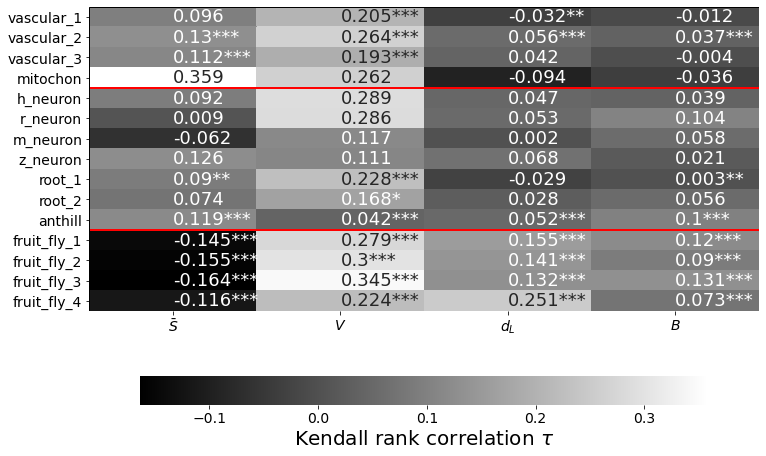

In [11]:
plt.figure(figsize=(12,8))
annot_kws = {"ha": 'left',"va": "center",'fontsize':18}
cbar_kws={'orientation': 'horizontal','use_gridspec':False,'label': 'Kendall rank correlation ' +  r'$\tau$',"shrink": 0.85}
#plt.title(corr_method + " correlation")
ax = sns.heatmap(df_full, annot=df_full_sig.values,fmt='',annot_kws=annot_kws,cbar_kws=cbar_kws,cmap='gray')
ax.hlines([4, 11], *ax.get_xlim(),colors='red',lw=2)
ax.hlines([0,15], *ax.get_xlim(),colors='black',lw=1)
ax.vlines([0,4], *ax.get_ylim(),colors='black',lw=1)
plt.savefig(corr_method + '_corr_heatmap.pdf', format='pdf',dpi=1200)

## Compl straightness check

human_neuron
rat_neuron
monkey_neuron
zebrafish_neuron
vascular_2
vascular_3
vascular_1
mitochondrial
root_1
root_2
anthill
fruit_fly_2
fruit_fly_3
fruit_fly_4
fruit_fly_1


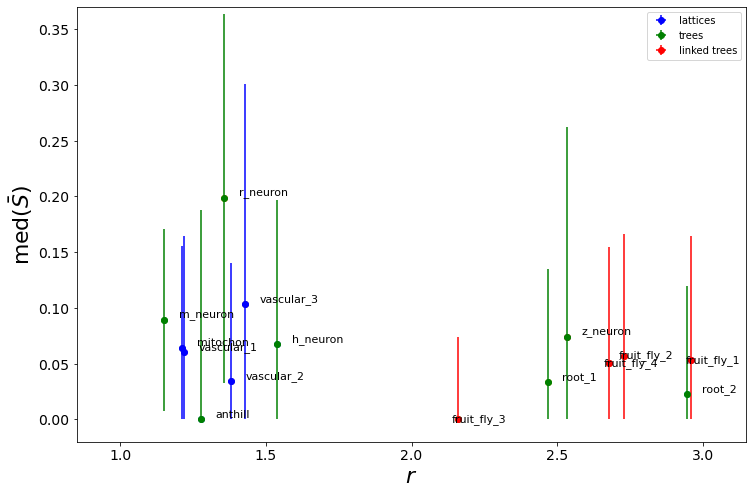

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Placeholder function definitions (assuming actual definitions are provided elsewhere)
def compute_iqr(values):
    # Placeholder for actual IQR computation
    return np.subtract(*np.percentile(values, [75, 25]))

# Assuming link_name_dictionary is correctly defined before this

# Initialize dictionaries for plot data and standard deviations
plot_dict = {}
plot_std_dict = {}
for name in link_name_dictionary.keys():
    plot_dict[name] = (compute_iqr(list(link_name_dictionary[name]['Link_volume']))/np.median(list(link_name_dictionary[name]['Link_volume'])),
                       np.median(list(link_name_dictionary[name]['Complementary_straightness'])))
    plot_std_dict[name] = (0,  # Assuming x-error is not applicable or is 0
                           compute_iqr(list(link_name_dictionary[name]['Complementary_straightness'])))



# Initialize plot data structures
l_x, l_y, l_x_error, l_y_error = [], [], [], []
t_x, t_y, t_x_error, t_y_error = [], [], [], []
cn_x, cn_y, cn_x_error, cn_y_error = [], [], [], []

# Assuming plot_dict and plot_std_dict are already defined
for name in plot_dict.keys():
    x, y = plot_dict[name]
    x_error, y_error = plot_std_dict[name]

    # Adjust only the bottom of the y-error bars, not to go below 0
    lower_y_error = y if y - y_error < 0 else y_error
    upper_y_error = y_error

    # Categorize and store data points based on group
    if 'vascular' in name or 'mito' in name:
        l_x.append(x)
        l_y.append(y)
        l_x_error.append(x_error)
        l_y_error.append([lower_y_error, upper_y_error])
    elif 'fruit_fly' in name:
        cn_x.append(x)
        cn_y.append(y)
        cn_x_error.append(x_error)
        cn_y_error.append([lower_y_error, upper_y_error])
    else:  # Assumes remaining categories are 'trees'
        t_x.append(x)
        t_y.append(y)
        t_x_error.append(x_error)
        t_y_error.append([lower_y_error, upper_y_error])

# Plotting error bars for each group with unique label and color
plt.figure(figsize=(12, 8))
for name in plot_dict.keys():
    print(name)
    x = plot_dict[name][0]
    y = plot_dict[name][1]
    plt.scatter(x, y)
    if name in name_change_dict.keys():
        name = name_change_dict[name]
   # plt.scatter(x, y)
    if 'fruit_fly' in name:
        plt.text(x - 0.02,y - 0.002, name, fontsize=11)
    else:
        plt.text(x + 0.05,y + 0.002, name, fontsize=11)
        
plt.errorbar(l_x, l_y, xerr=l_x_error, yerr=np.array(l_y_error).T, fmt='o', color='blue', label='lattices')
plt.errorbar(t_x, t_y, xerr=t_x_error, yerr=np.array(t_y_error).T, fmt='o', color='green', label='trees')
plt.errorbar(cn_x, cn_y, xerr=cn_x_error, yerr=np.array(cn_y_error).T, fmt='o', color='red', label='linked trees')

# Final adjustments to the plot
plt.ylabel(r'med($\bar{S}$)', fontsize=22)
plt.xlabel(r'$r$', fontsize=22)
plt.legend(loc='upper right')
plt.xlim(0.85, 3.15)  # Adjust as necessary
plt.ylim(-0.02,0.37)
plt.savefig('link_cs_volume_grouped.pdf', format='pdf', dpi=1200)

In [15]:
volume_dict = {'name':[],'mean_link_volume':[],'std_link_volume':[],'mean_link_cs':[],'std_link_cs':[]}
path_save = '3.link_df_properties/'
for name in link_name_dictionary.keys():
    volume_dict['name'].append(name)
    volume_dict['mean_link_volume'].append(np.mean(list(link_name_dictionary[name]['Link_volume'])))
    volume_dict['std_link_volume'].append(np.std(list(link_name_dictionary[name]['Link_volume'])))
    volume_dict['mean_link_cs'].append(np.mean(list(link_name_dictionary[name]['Complementary_straightness'])))
    volume_dict['std_link_cs'].append(np.std(list(link_name_dictionary[name]['Complementary_straightness'])))

In [16]:
def gini_coefficient(values):
    # Sort the values
    values = np.sort(values)
    n = len(values)
    cumulative_sum = np.cumsum(values)
    # Calculate the Gini coefficient using its formula
    gini = (n + 1 - 2 * np.sum(cumulative_sum) / cumulative_sum[-1]) / n
    return gini

def calculate_gini_distributions(dist,n_distributions,normalize):
    gini_values = []
    for _ in range(n_distributions):
        if dist == 'uniform':
            dist_arr = np.random.uniform(0, 1, size)
        if dist == 'normal':
            dist_arr =  np.random.normal(0, 1, size)
        if dist == 'exponential':
            dist_arr = np.random.exponential(1, 1000)
        if normalize == True:
            dist_arr = dist_arr - np.min(dist_arr)  # Normalize if normal distribution
        gini_values.append(gini_coefficient(dist_arr))
    return gini_values

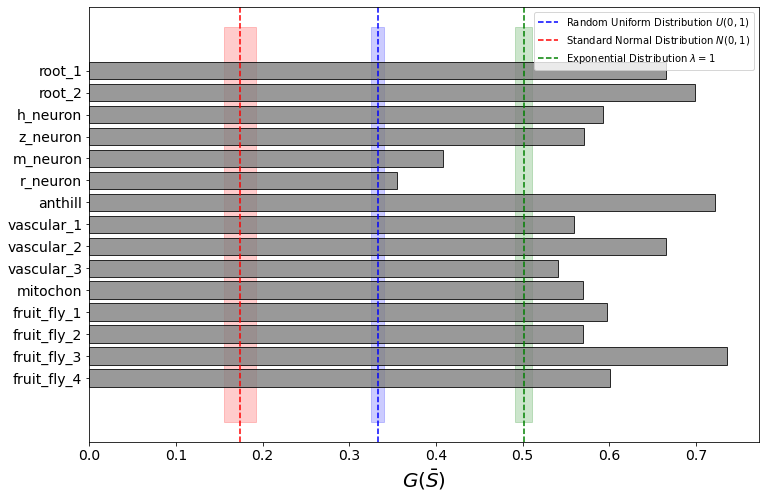

In [17]:
gini_dict = {}
for name in ordered_name_list:
    if name in name_change_dict:
        gini_dict[name_change_dict[name]] = gini_coefficient(link_name_dictionary[name]['Complementary_straightness'])
    else:
        gini_dict[name] = gini_coefficient(link_name_dictionary[name]['Complementary_straightness'])
uniform_dist = np.random.uniform(0, 1, 1000)
normal_dist = np.random.normal(0, 1, 1000)
normal_dist_normalized = normal_dist - np.min(normal_dist)  
gini_uniform = gini_coefficient(uniform_dist)
gini_normal = gini_coefficient(normal_dist_normalized )


n_distributions = 100
size = 1000

gini_uniform_values = calculate_gini_distributions('uniform', n_distributions,False)
gini_normal_values = calculate_gini_distributions('normal',n_distributions,True)
gini_exponential_values =calculate_gini_distributions('exponential',n_distributions,True)

mean_gini_uniform = np.mean(gini_uniform_values)
std_gini_uniform = np.std(gini_uniform_values)
mean_gini_normal = np.mean(gini_normal_values)
std_gini_normal = np.std(gini_normal_values)
mean_gini_exponential = np.mean(gini_exponential_values)
std_gini_exponential = np.std(gini_exponential_values)



plt.figure(figsize=(12,8))
plt.barh(list(gini_dict.keys())[::-1],list(gini_dict.values())[::-1],color='gray',alpha=0.8,edgecolor='black')
plt.xlabel(r'$G(\bar{S})$');
plt.savefig('gini_coefficient.pdf', format='pdf',dpi=1200)
plt.axvline(x=mean_gini_uniform, color='blue', linestyle='--', label='Random Uniform Distribution $U(0,1)$')
plt.axvline(x=mean_gini_normal, color='red', linestyle='--', label='Standard Normal Distribution $N(0,1)$')
plt.axvline(x=mean_gini_exponential, color='green', linestyle='--', label='Exponential Distribution $\lambda = 1$')
y_range = np.arange(-2, len(gini_dict) + 2)
plt.fill_betweenx(y=y_range, x1=mean_gini_uniform-std_gini_uniform, x2=mean_gini_uniform+std_gini_uniform, color='blue', alpha=0.2)
plt.fill_betweenx(y=y_range, x1=mean_gini_normal-std_gini_normal, x2=mean_gini_normal+std_gini_normal, color='red', alpha=0.2)
plt.fill_betweenx(y=y_range, x1=mean_gini_exponential-std_gini_exponential, x2=mean_gini_exponential+std_gini_exponential, color='green', alpha=0.2)
# Adding a legend to show line labels
plt.legend()
plt.savefig('gini_coefficient.pdf', format='pdf', dpi=1200)

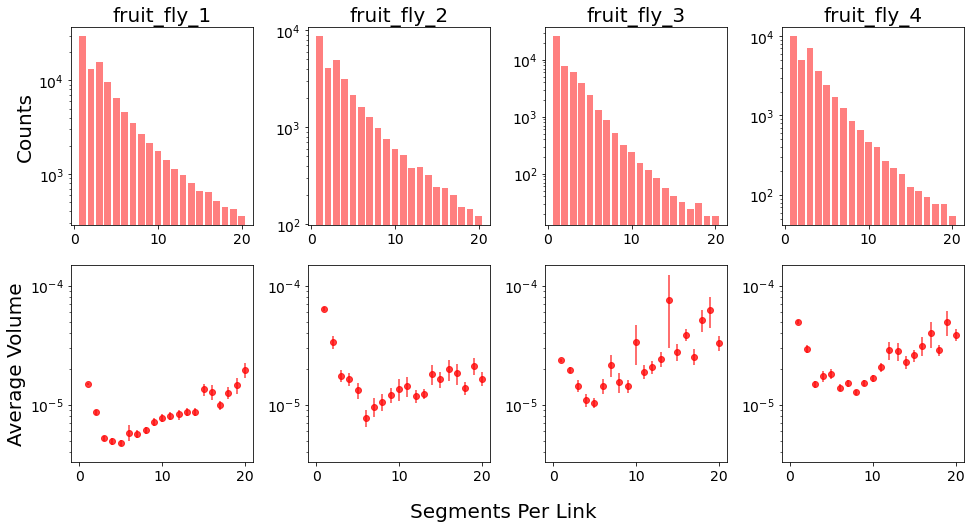

In [18]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np


fig, axs = plt.subplots(2, 4, figsize=(16, 8), gridspec_kw={'hspace': 0.2, 'wspace': 0.3})
fruit_fly_datasets = ['fruit_fly_1', 'fruit_fly_2', 'fruit_fly_3', 'fruit_fly_4']
for idx, name in enumerate(fruit_fly_datasets):
    segment_volumes = defaultdict(list)
    volume_list = link_name_dictionary[name]['Link_volume']
    link_segments_list = link_name_dictionary[name]['Link_segments']
    for volume, segment in zip(volume_list, link_segments_list):
        segment_volumes[segment].append(volume)

    # Calculate average volume, standard error, and counts for each segment
    avg_volumes = {}
    std_errors = {}
    counts = {}

    for segment, volumes in segment_volumes.items():
        if segment <= 20:  # Limiting to 30 segments
            avg_volumes[segment] = np.mean(volumes)
            std_errors[segment] = np.std(volumes) / np.sqrt(len(volumes))
            counts[segment] = len(volumes)
    
    # Plotting Counts in the first row
    axs[0, idx].bar(counts.keys(), counts.values(),alpha=0.5,color='red')
    axs[0, idx].set_yscale('log')
    axs[0, idx].set_title(name)
    #axs[0, idx].set_xlabel('Segments Per Link')
    if idx == 0:
        axs[0, idx].set_ylabel('Counts', fontsize=20)

    # Plotting Average Volume with Standard Error in the second row
    axs[1, idx].errorbar(avg_volumes.keys(), avg_volumes.values(), yerr=std_errors.values(), fmt='o',alpha=0.75,color='red')
    axs[1, idx].set_yscale('log')
    #axs[1, idx].set_xlabel('Segments Per Link')
    #axs[1, idx].set_ylabel('Average Volume')
    axs[1, idx].set_ylim(0.33* 10**(-5), 1.5 * 10**(-4))
    if idx == 0:
        axs[1, idx].set_ylabel('Average Volume', fontsize=20)
    axs[1, idx].set_xticks([0,10,20])
    axs[1, idx].set_xlim(-1,21)
fig.text(0.5, 0.04, 'Segments Per Link', ha='center', va='center', fontsize=20)
plt.savefig('segments_volumes_per_link.pdf', format='pdf', dpi=1200)

In [19]:
def perform_mann_whitney_u_test(group1, group2):
    """
    Perform Mann-Whitney U test for comparison between two groups.

    :param group1: Data for the first group.
    :param group2: Data for the second group.
    :return: The p-value of the test as a float.
    """
    _, p_val = stats.mannwhitneyu(group1, group2, alternative='two-sided')
    return p_val  # Return only the p-value as a float

In [20]:
# Create a PDF file to save the plots
ks_test_results = {}
#with PdfPages('network_analysis_plots.pdf') as pdf:
medians_and_iqr = []
medians_iqr_non_zero = []
medians_iqr_zero = []

top_dfs = {}
bottom_dfs = {}
ks_mw_test_results = {name: {} for name in name_list}
for name in name_list:
    top_df = top_dfs_dict[name]
    bottom_df = bottom_dfs_dict[name]
    for prop in link_dictionary.keys():
        top_data = top_df[prop]
        bottom_data = bottom_df[prop]
        # Calculate medians and IQR for each property
        top_median = top_df[prop].median()
        bottom_median = bottom_df[prop].median()
        top_iqr = top_df[prop].quantile(0.75) - top_df[prop].quantile(0.25)
        bottom_iqr = bottom_df[prop].quantile(0.75) - bottom_df[prop].quantile(0.25)

        # Format as 'median ± IQR'
        medians_and_iqr.append((name, f'{prop} (Non-Zero Confinement Median ± IQR)', f"{top_median:.4f} ± {top_iqr:.4f}"))
        medians_and_iqr.append((name, f'{prop} (Zero Confinement Median ± IQR)', f"{bottom_median:.4f} ± {bottom_iqr:.4f}"))
        
        medians_iqr_non_zero.append((name, prop, f"{top_median:.6f} ± {top_iqr:.6f}"))
        medians_iqr_zero.append((name, prop, f"{bottom_median:.6f} ± {bottom_iqr:.6f}"))
         # Perform KS Test
        ks_statistic, ks_p_value = stats.ks_2samp(top_data, bottom_data)

        # Perform Mann-Whitney U Test
        mw_p_value = perform_mann_whitney_u_test(top_data, bottom_data)

        # Store the p-values in the dictionary
        ks_mw_test_results[name][prop] = {'KS P-Value': ks_p_value, 'MW P-Value': mw_p_value}
# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame.from_dict({(i, j): ks_mw_test_results[i][j]
                                     for i in ks_mw_test_results.keys()
                                     for j in ks_mw_test_results[i].keys()},
                                    orient='index')

# Optional: Rename the index for clarity
# Convert the medians and IQRs dictionary to a DataFrame


medians_iqr_non_zero_df = pd.DataFrame(medians_iqr_non_zero, columns=['Network', 'Property', 'Non-Zero Confinement Median ± IQR']).set_index(['Network', 'Property'])
medians_iqr_zero_df = pd.DataFrame(medians_iqr_zero, columns=['Network', 'Property', 'Zero Confinement Median ± IQR']).set_index(['Network', 'Property'])

# Concatenate the two DataFrames into one DataFrame with two columns
medians_iqr_df = pd.concat([medians_iqr_non_zero_df, medians_iqr_zero_df], axis=1)

# Optional: Rename the index for clarity


results_df.index.names = ['Network', 'Property']

In [21]:
threshold = 0.01 # Set your threshold value here

# Filter the DataFrame
filtered_results_df = results_df[(results_df['KS P-Value'] < threshold) & (results_df['MW P-Value'] < threshold)].round(4)
results_df['KS P-Value'] = results_df.apply(lambda x: 1 if x['KS P-Value'] < threshold else 0,axis=1)
results_df['MW P-Value'] = results_df.apply(lambda x: 1 if x['MW P-Value'] < threshold else 0,axis=1)
results_df['sig_tests'] = results_df.apply(lambda x: x['MW P-Value'] + x['KS P-Value'],axis=1)
results_df = results_df[['sig_tests']]
results_df

sig_tests
Network      Property                             
human_neuron Path_id                             0
             Complementary_straightness          2
             Link_volume                         2
             Link_confinement                    2
             Link_degree                         0
...                                            ...
fruit_fly_1  Link_confinement                    2
             Link_degree                         2
             Link_betw                           2
             Link_path_length                    1
             Link_segments                       2

[120 rows x 1 columns]

<Figure size 720x576 with 0 Axes>

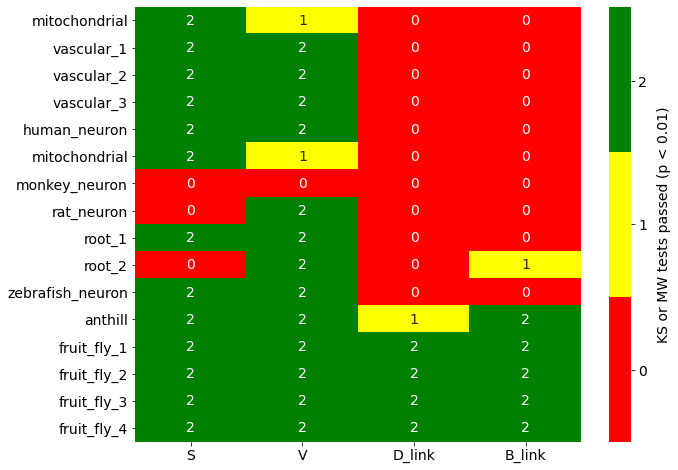

In [22]:

import matplotlib.colors as mcolors
heatmap_data = results_df.unstack(level='Property')

# Dropping the 'sig_tests' level in columns if it's there
if isinstance(heatmap_data.columns, pd.MultiIndex):
    heatmap_data.columns = heatmap_data.columns.droplevel(0)
    
heatmap_data = heatmap_data[['Complementary_straightness','Link_volume','Link_degree','Link_betw']]
heatmap_data.columns = ['S','V','D_link','B_link']
custom_order =['mitochondrial', 'vascular_1', 'vascular_2', 'vascular_3',
       'human_neuron', 'mitochondrial', 'monkey_neuron', 'rat_neuron',
       'root_1', 'root_2',
       'zebrafish_neuron','anthill', 'fruit_fly_1', 'fruit_fly_2', 'fruit_fly_3', 'fruit_fly_4']

heatmap_data = heatmap_data.reindex(custom_order)
# Creating the heatmap
plt.figure(figsize=(10, 8))

# Define a color map with three colors

cmap = mcolors.ListedColormap(['red', 'yellow', 'green'])

# Creating the heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(heatmap_data, annot=True, cmap=cmap, linewidths=0, cbar=True, fmt='d',annot_kws={"size": 14})

ax.figure.axes[-1].set_ylabel('KS or MW tests passed (p < 0.01)', size=14, labelpad=10)

# Setting colorbar ticks to [0, 1, 2]
cbar = ax.collections[0].colorbar
cbar.set_ticks([0.33, 1, 1.66])
cbar.set_ticklabels([0, 1, 2])
#plt.title('Heatmap of Significant Tests')
plt.xlabel('')
plt.ylabel('')
plt.savefig('dist_tests.pdf', format='pdf',dpi=1200)



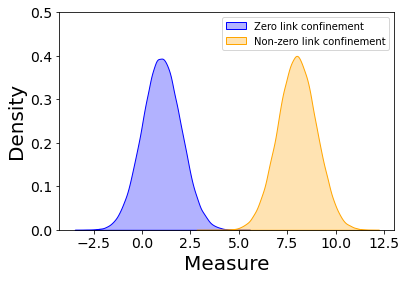

In [23]:
# Generating and plotting KDE for two normal distributions

# Parameters for the normal distributions
# Distribution 1
mean1, std1 = 1, 1

# Distribution 2
mean2, std2 = 8, 1

# Generating sample data
data1 = np.random.normal(mean1, std1, 100000)
data2 = np.random.normal(mean2, std2, 100000)

# Plotting the KDEs
sns.kdeplot(data1, label='Zero link confinement', color='blue', fill=True, alpha=0.3)
sns.kdeplot(data2, label='Non-zero link confinement', color='orange', fill=True, alpha=0.3)
plt.xlabel('Measure')
plt.legend()
plt.ylim(0,0.5)
plt.savefig('two_distributions.pdf', format='pdf',dpi=1200)